# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Alexis Perumal, 12/15/19
# UCSD Data Science Bootcamp, HW #6 Python API, WeatherPy project

# Shell commands used to diagnose why the api_keys.py files wasn't being read correctly.
# !conda list
# !sys path
# !pwd
# !ls
# !cat api_keys.py

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import pprint
import datetime as dt
from scipy import stats

from api_keys import open_weather_key  # Make sure the key is not included in github repo!

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy # Anaconda doesn't have it so do: "pip install citypy" in the env.
# To get this environment to work in Jupyter Notebook: https://janakiev.com/blog/jupyter-virtual-envs/
# Better:
# conda install nb_conda
# From https://stackoverflow.com/questions/37085665/in-which-conda-environment-is-jupyter-executing/39070588


import shelve  # Use to store data across instance runs so we don't have to actually hit the
                # Web everytime. This is helpful for dev & debug.


# Constants

# Data Source:
#   0: Fresh random numbers (lat&long), and pull weather from the web, but don't archive results.
#   1: Fresh random numbers & real time pull, with archival in the shelf file.
#   2: Retrieve city list and weather from the shelf file. No real time Web API query.
DATA_FRESHNESS = 1

SHELF_FNAME = "cities_and_weather"

if DATA_FRESHNESS == 1 or DATA_FRESHNESS == 2:
    shelf_file = shelve.open(SHELF_FNAME)

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)
print("OK, ready to go!")
%pwd
print(shelf_file)
!pwd
pprint.pprint(shelf_file)
# print(shelf_file['cities'])

OK, ready to go!
/Users/aperumal/OneDrive/Personal/UCSD_Data_Science_Bootcamp/Homework/2019-12-15_HW6_Python_API/python-api-challenge


## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
def build_city_list():
    lat_lngs = []
    cities = []

    cities.append('bogus_city') # Put a bugus city name at the front to ensure the code works
                                # well when there isn't a match on the city search.

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
    lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
    lat_lngs = zip(lats, lngs)

    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)

    # Print the city count to confirm sufficient count
    len(cities)
    return cities

if DATA_FRESHNESS == 0 or DATA_FRESHNESS == 1:  # Generate the data
    cities = build_city_list()
    if DATA_FRESHNESS == 1: # Archive the city list in the shelf file.
        shelf_file['cities'] = cities
        # shelf_file.close()
else:  # Get the data from the shelf file.
    print("Retrieving the data from the shelf file.")
    cities = shelf_file['cities']
    
len(cities)
# shelf_file.close()
# cities

637

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# Setup openweather base URL with everything but the city name.
ow_base_url = "http://api.openweathermap.org/data/2.5/weather?"+ "appid=" + open_weather_key + "&units=metric" + "&q="
city = "Poway"

query_url = ow_base_url + city

In [5]:
response = requests.get(query_url)
weather = response.json()

temp = weather['main']['temp']
lat = weather['coord']['lat']
timestamp = weather['dt']
date_time = dt.datetime.utcfromtimestamp(timestamp)
print(f"  {city}: temp={temp}, lat={lat}, Date/Time={date_time}")
pprint.pprint(weather)

  Poway: temp=6.34, lat=32.96, Date/Time=2019-12-28 07:27:00
{'base': 'stations',
 'clouds': {'all': 1},
 'cod': 200,
 'coord': {'lat': 32.96, 'lon': -117.04},
 'dt': 1577518020,
 'id': 5384690,
 'main': {'feels_like': 4.78,
          'humidity': 93,
          'pressure': 1016,
          'temp': 6.34,
          'temp_max': 12.22,
          'temp_min': -1.11},
 'name': 'Poway',
 'rain': {'1h': 0.25},
 'sys': {'country': 'US',
         'id': 5686,
         'sunrise': 1577458173,
         'sunset': 1577494116,
         'type': 1},
 'timezone': -28800,
 'visibility': 4828,
 'weather': [{'description': 'light rain',
              'icon': '10n',
              'id': 500,
              'main': 'Rain'},
             {'description': 'mist', 'icon': '50n', 'id': 701, 'main': 'Mist'}],
 'wind': {'deg': 77, 'speed': 0.71}}


In [6]:
def get_weather(cities):  
    # Setup openweather base URL with everything but the city name.
    ow_base_url = "http://api.openweathermap.org/data/2.5/weather?"+ "appid=" + open_weather_key + "&units=metric" + "&q="

    set = 1
    i = 1
    found_cities = []
    country_list = []
    temp_list = []
    humidity_list = []
    cloudiness_list = []
    windspeed_list = []
    lat_list = []
    long_list = []
    time_list = []
    time_sunrise_list = []
    time_sunset_list = []
    timezone_offset_list = []
    for city in cities:
        # url = query_base_url+city
        response = requests.get(ow_base_url+city)
        if response.status_code == 404:
            print("City not found (404 Error). Skipping...")
        else:
            print(f"Processing Record {i} of Set {set} | {city}")
            found_cities.append(city)
            weather = response.json()
            #pprint.pprint(weather)
            country = weather['sys']['country']
            temp = weather['main']['temp']
            humidity = weather['main']['humidity']
            cloudiness = weather['clouds']['all']
            windspeed = weather['wind']['speed']
            lat = weather['coord']['lat']
            long = weather['coord']['lon']
            date_time = dt.datetime.utcfromtimestamp(weather['dt'])
#             time_sunrise = weather['sys']['sunrise']
#             time_sunset = weather['sys']['sunset']
#             timezone_offset = weather['timezone']
            # print(f"  {city}: temp={temp}, lat={lat}")
            
            country_list.append(country)
            temp_list.append(temp)
            humidity_list.append(humidity)
            cloudiness_list.append(cloudiness)
            windspeed_list.append(windspeed)
            lat_list.append(lat)
            long_list.append(long)
            time_list.append(date_time)
#             time_sunrise_list.append(time_sunrise)
#             time_sunset_list.append(time_sunset)
#             timezone_offset_list.append(timezone_offset)
            
            print(f"City: {city}")
            time.sleep(0.01)
            i+=1
            
#             if i == 30:  # break early for debugging
#                 break

#
#     weather = pd.DataFrame({'City':found_cities, 'Country':country_list, 'Temp': temp_list, 'Humidity':humidity_list, 'Cloud %':cloudiness_list,
#                             'Windspeed':windspeed_list, 'Lat':lat_list, 'Long':long_list, 'Time':time_list,
#                             'Sunrise':time_sunrise_list, 'Sunset':time_sunset_list, 'TZ offset':timezone_offset_list})
    weather = pd.DataFrame({'City':found_cities, 'Country':country_list, 'Temp': temp_list, 'Humidity':humidity_list, 'Cloud %':cloudiness_list,
                            'Windspeed':windspeed_list, 'Lat':lat_list, 'Long':long_list, 'Time':time_list})
    return weather

#   0: Fresh random numbers (lat&long), and pull weather from the web, but don't archive results.
#   1: Fresh random numbers & real time pull, with archival in the shelf file.
#   2: Retrieve city list and weather from the shelf file. No real time Web API query.

print(len(cities))

if DATA_FRESHNESS == 0 or DATA_FRESHNESS == 1: # Retrieve Weather Data from API
    weather = get_weather(cities)
    if DATA_FRESHNESS == 1: # Archive the city list in the shelf file.
        shelf_file['weather'] = weather
        shelf_file.close()
else:  # Get the data from the shelf file.
    print("Retrieving the data from the shelf file.")
    weather = shelf_file['weather']
    shelf_file.close()
    

print(len(weather['Temp']))




637
City not found (404 Error). Skipping...
Processing Record 1 of Set 1 | obihiro
City: obihiro
Processing Record 2 of Set 1 | coquimbo
City: coquimbo
Processing Record 3 of Set 1 | kahului
City: kahului
Processing Record 4 of Set 1 | busselton
City: busselton
Processing Record 5 of Set 1 | butaritari
City: butaritari
Processing Record 6 of Set 1 | senneterre
City: senneterre
Processing Record 7 of Set 1 | ramanuj ganj
City: ramanuj ganj
Processing Record 8 of Set 1 | nanortalik
City: nanortalik
Processing Record 9 of Set 1 | pochutla
City: pochutla
Processing Record 10 of Set 1 | saldanha
City: saldanha
Processing Record 11 of Set 1 | clyde river
City: clyde river
Processing Record 12 of Set 1 | mehamn
City: mehamn
Processing Record 13 of Set 1 | airai
City: airai
Processing Record 14 of Set 1 | great falls
City: great falls
Processing Record 15 of Set 1 | rikitea
City: rikitea
Processing Record 16 of Set 1 | ushuaia
City: ushuaia
Processing Record 17 of Set 1 | boromo
City: boromo
P

Processing Record 138 of Set 1 | leningradskiy
City: leningradskiy
Processing Record 139 of Set 1 | saint anthony
City: saint anthony
Processing Record 140 of Set 1 | vernon
City: vernon
Processing Record 141 of Set 1 | mandalgovi
City: mandalgovi
Processing Record 142 of Set 1 | la baneza
City: la baneza
Processing Record 143 of Set 1 | dodge city
City: dodge city
Processing Record 144 of Set 1 | pangai
City: pangai
Processing Record 145 of Set 1 | kudahuvadhoo
City: kudahuvadhoo
Processing Record 146 of Set 1 | thompson
City: thompson
Processing Record 147 of Set 1 | bilma
City: bilma
Processing Record 148 of Set 1 | katsuura
City: katsuura
Processing Record 149 of Set 1 | katete
City: katete
Processing Record 150 of Set 1 | mahebourg
City: mahebourg
Processing Record 151 of Set 1 | cherskiy
City: cherskiy
Processing Record 152 of Set 1 | carnarvon
City: carnarvon
Processing Record 153 of Set 1 | travesia
City: travesia
City not found (404 Error). Skipping...
City not found (404 Erro

Processing Record 271 of Set 1 | kavaratti
City: kavaratti
Processing Record 272 of Set 1 | kavieng
City: kavieng
Processing Record 273 of Set 1 | poya
City: poya
Processing Record 274 of Set 1 | bilibino
City: bilibino
Processing Record 275 of Set 1 | kapuskasing
City: kapuskasing
City not found (404 Error). Skipping...
Processing Record 276 of Set 1 | goreloye
City: goreloye
Processing Record 277 of Set 1 | nerchinskiy zavod
City: nerchinskiy zavod
Processing Record 278 of Set 1 | ancud
City: ancud
Processing Record 279 of Set 1 | wagar
City: wagar
Processing Record 280 of Set 1 | makakilo city
City: makakilo city
Processing Record 281 of Set 1 | rincon
City: rincon
Processing Record 282 of Set 1 | longyearbyen
City: longyearbyen
Processing Record 283 of Set 1 | boguchany
City: boguchany
City not found (404 Error). Skipping...
Processing Record 284 of Set 1 | pisco
City: pisco
Processing Record 285 of Set 1 | arlit
City: arlit
Processing Record 286 of Set 1 | tigil
City: tigil
Proces

Processing Record 402 of Set 1 | lisakovsk
City: lisakovsk
Processing Record 403 of Set 1 | qasigiannguit
City: qasigiannguit
Processing Record 404 of Set 1 | vestmannaeyjar
City: vestmannaeyjar
City not found (404 Error). Skipping...
Processing Record 405 of Set 1 | pingdingshan
City: pingdingshan
Processing Record 406 of Set 1 | marsh harbour
City: marsh harbour
City not found (404 Error). Skipping...
Processing Record 407 of Set 1 | okhotsk
City: okhotsk
Processing Record 408 of Set 1 | casablanca
City: casablanca
Processing Record 409 of Set 1 | vardo
City: vardo
Processing Record 410 of Set 1 | wellington
City: wellington
Processing Record 411 of Set 1 | san cristobal
City: san cristobal
Processing Record 412 of Set 1 | smithers
City: smithers
Processing Record 413 of Set 1 | austin
City: austin
Processing Record 414 of Set 1 | derac
City: derac
Processing Record 415 of Set 1 | greeneville
City: greeneville
Processing Record 416 of Set 1 | kautokeino
City: kautokeino
Processing Re

Processing Record 532 of Set 1 | fort wellington
City: fort wellington
Processing Record 533 of Set 1 | mataram
City: mataram
Processing Record 534 of Set 1 | kodinar
City: kodinar
Processing Record 535 of Set 1 | lagunas
City: lagunas
Processing Record 536 of Set 1 | pereira barreto
City: pereira barreto
Processing Record 537 of Set 1 | kloulklubed
City: kloulklubed
City not found (404 Error). Skipping...
Processing Record 538 of Set 1 | kabare
City: kabare
Processing Record 539 of Set 1 | aksehir
City: aksehir
Processing Record 540 of Set 1 | colares
City: colares
Processing Record 541 of Set 1 | naze
City: naze
Processing Record 542 of Set 1 | hammond
City: hammond
Processing Record 543 of Set 1 | sangar
City: sangar
Processing Record 544 of Set 1 | najran
City: najran
Processing Record 545 of Set 1 | novy bor
City: novy bor
Processing Record 546 of Set 1 | cherlak
City: cherlak
City not found (404 Error). Skipping...
Processing Record 547 of Set 1 | atambua
City: atambua
Processing

In [7]:
pprint.pprint(weather)

                         City Country   Temp  Humidity  Cloud %  Windspeed  \
0                     obihiro      JP  -5.00        57       20       5.10   
1                    coquimbo      CL  14.00        87       84       0.50   
2                     kahului      US  21.53        83       20       4.60   
3                   busselton      AU  29.11        31        0       7.89   
4                  butaritari      KI  28.97        77      100       5.96   
..                        ...     ...    ...       ...      ...        ...   
569                    solkan      IT   0.53        70        0       1.00   
570                  misratah      LY  16.69        72        0      10.37   
571  sao jose da coroa grande      BR  26.26        69       12       4.67   
572                     nyrob      RU  -7.82        89      100       4.41   
573                    hirara      JP  20.51        68       75       4.60   

       Lat    Long                Time  
0    42.92  143.20 201

In [8]:
date_str = str(weather.iloc[0]['Time'])[:10]
year = date_str[:4]
month = date_str[5:7]
day = date_str[-2:]
extract_date_str = f"{month}/{day}/{year}"
extract_date_str

'12/28/2019'

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | lompoc
Processing Record 2 of Set 1 | klaksvik
Processing Record 3 of Set 1 | bisignano
Processing Record 4 of Set 1 | bengkulu
City not found. Skipping...
Processing Record 5 of Set 1 | hilo
Processing Record 6 of Set 1 | rikitea
Processing Record 7 of Set 1 | ahipara
Processing Record 8 of Set 1 | lebu
Processing Record 9 of Set 1 | hamilton
Processing Record 10 of Set 1 | castro
Processing Record 11 of Set 1 | ashland
Processing Record 12 of Set 1 | ushuaia
Processing Record 13 of Set 1 | haines junction
Processing Record 14 of Set 1 | punta arenas
Processing Record 15 of Set 1 | salalah
Processing Record 16 of Set 1 | port macquarie
Processing Record 17 of Set 1 | mataura
Processing Record 18 of Set 1 | saint-philippe
Processing Record 19 of Set 1 | kaitangata
Processing Record 20 of Set 1 | souillac
Processing Record 21 of Set 1 | srednekolymsk
Processing Record 22 of Set 1 | busselton
Proce

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
weather.to_csv("weather.csv")
print(len(weather))
weather.head()

574


,City,Country,Temp,Humidity,Cloud %,Windspeed,Lat,Long,Time
0,obihiro,JP,-5.00,57,20,5.10,42.92,143.20,2019-12-28 07:30:47
1,coquimbo,CL,14.00,87,84,0.50,-29.95,-71.34,2019-12-28 07:30:48
2,kahului,US,21.53,83,20,4.60,20.89,-156.47,2019-12-28 07:30:48
3,busselton,AU,29.11,31,0,7.89,-33.64,115.35,2019-12-28 07:30:48
4,butaritari,KI,28.97,77,100,5.96,3.07,172.79,2019-12-28 07:30:48


City          547
Cloudiness    547
Country       547
Date          547
Humidity      547
Lat           547
Lng           547
Max Temp      547
Wind Speed    547
dtype: int64

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,lompoc,1,US,1534984500,44,34.64,-120.46,77.00,11.41
1,klaksvik,92,FO,1534983600,100,62.23,-6.59,50.00,13.87
2,bisignano,0,IT,1534981800,88,39.50,16.27,66.20,5.82
3,hilo,90,US,1534984860,90,19.71,-155.08,77.00,8.05
4,rikitea,8,PF,1534986579,100,-23.12,-134.97,69.58,19.71


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

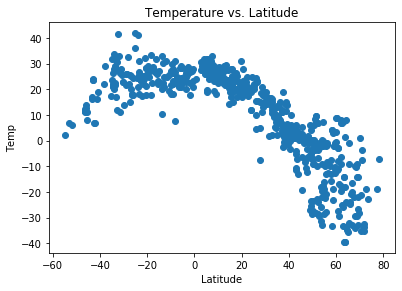

In [10]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.set_xlabel('Latitude')
axes.set_ylabel('Temp')
axes.set_title('Temperature vs. Latitude')
axes.scatter(weather['Lat'], weather['Temp'])

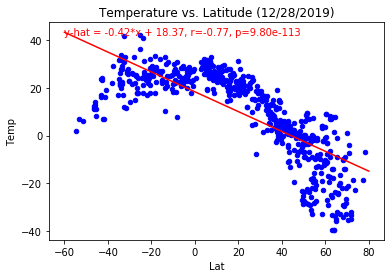

In [12]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat'], weather['Temp'])
weather.plot.scatter(x='Lat', y='Temp', color='Blue',
                     title=f"Temperature vs. Latitude ({extract_date_str})")
x = [-60, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.text(-60, 42, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('temp-vs-lat.png', dpi=100)
plt.show()

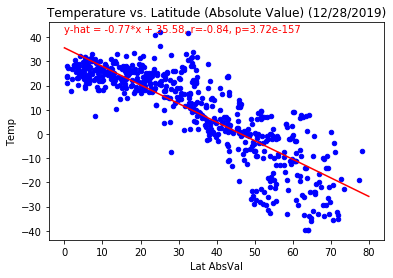

In [13]:
weather['Lat AbsVal'] = weather['Lat'].abs()
slope, int, r_val, p_val, se = stats.linregress(weather['Lat AbsVal'], weather['Temp'])
weather.plot.scatter(x='Lat AbsVal', y='Temp', color='Blue',
                     title=f"Temperature vs. Latitude (Absolute Value) ({extract_date_str})")
x = [0, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.text(0, 42, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('temp-vs-lat-abs.png', dpi=100)
plt.show()

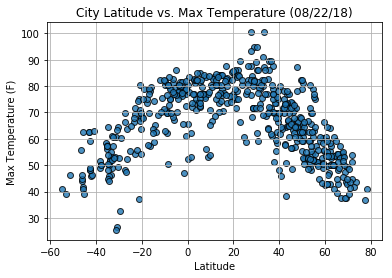

#### Latitude vs. Humidity Plot

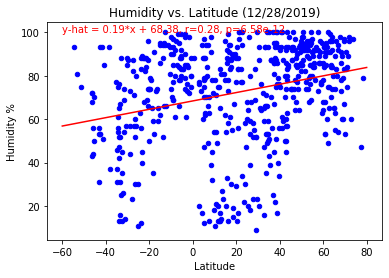

In [14]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat'], weather['Humidity'])
weather.plot.scatter(x='Lat', y='Humidity', color='Blue',
                     title=f"Humidity vs. Latitude ({extract_date_str})")
x = [-60, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude')
plt.ylabel('Humidity %')
plt.text(-60, 100, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Humidity-vs-lat.png', dpi=100)
plt.show()

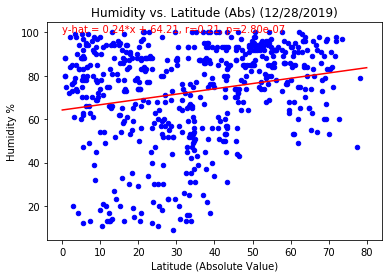

In [15]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat AbsVal'], weather['Humidity'])
weather.plot.scatter(x='Lat AbsVal', y='Humidity', color='Blue',
                     title=f"Humidity vs. Latitude (Abs) ({extract_date_str})")
x = [0, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude (Absolute Value)')
plt.ylabel('Humidity %')
plt.text(0, 100, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Humidity-vs-lat-abs.png', dpi=100)
plt.show()

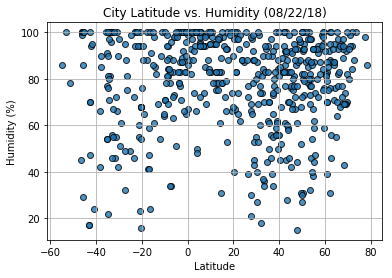

#### Latitude vs. Cloudiness Plot

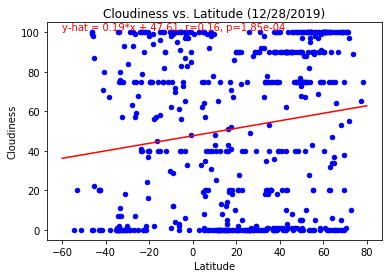

In [17]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat'], weather['Cloud %'])
weather.plot.scatter(x='Lat', y='Cloud %', color='Blue',
                     title=f"Cloudiness vs. Latitude ({extract_date_str})")
x = [-60, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.text(-60, 101, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Cloudiness-vs-lat.png', dpi=100)
plt.show()

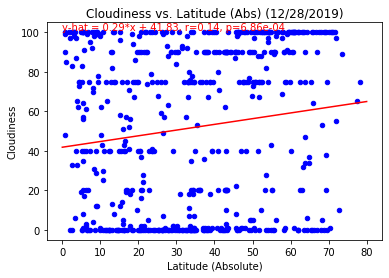

In [19]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat AbsVal'], weather['Cloud %'])
weather.plot.scatter(x='Lat AbsVal', y='Cloud %', color='Blue',
                     title=f"Cloudiness vs. Latitude (Abs) ({extract_date_str})")
x = [0, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude (Absolute)')
plt.ylabel('Cloudiness')
plt.text(0, 101, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Cloudiness-vs-lat-abs.png', dpi=100)
plt.show()

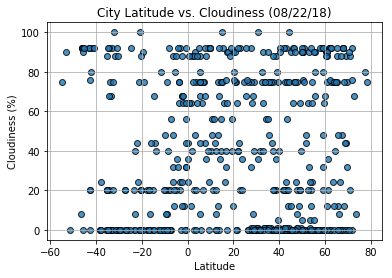

#### Latitude vs. Wind Speed Plot

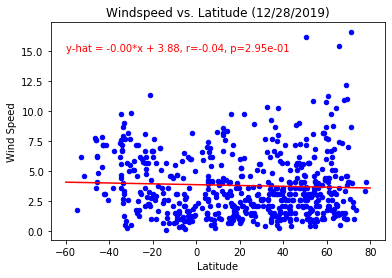

In [21]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat'], weather['Windspeed'])
weather.plot.scatter(x='Lat', y='Windspeed', color='Blue',
                     title=f"Windspeed vs. Latitude ({extract_date_str})")
x = [-60, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.text(-60, 15, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Wind-vs-lat.png', dpi=100)
plt.show()

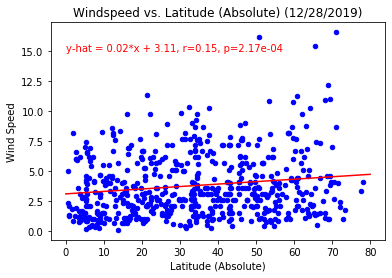

In [23]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat AbsVal'], weather['Windspeed'])
weather.plot.scatter(x='Lat AbsVal', y='Windspeed', color='Blue',
                     title=f"Windspeed vs. Latitude (Absolute) ({extract_date_str})")
x = [0, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude (Absolute)')
plt.ylabel('Wind Speed')
plt.text(0, 15, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Wind-vs-lat-abs.png', dpi=100)
plt.show()

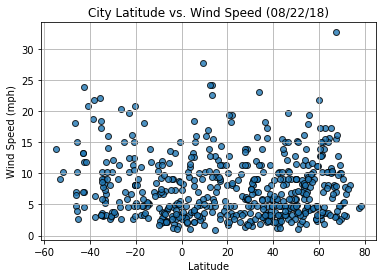

Weather Analysis and Findings
Alexis Perumal, 12/28/19
UCSD Data Science Bootcamp, HW#6 Python-API


Summary

Analysis attempting to understand the correlation between latitude and four weather indicators (temperature, Humidity, Cloudiness and Windspeed).  


Approach

Analysis was done by hitting the OpenWeather API REST endpoint and extracting real time weather data for 500+ cities randomly selected from around the world.


Findings

1.	Temperature correlates inversely with latitude with statistical significance.

Statistical significance is very strong p=9.8E-113 and the inverse correlation is also strong (r=-0.77, m=-0.42 degrees C per degree of latitude).

Statistical significance is even stronger, p=3.7E-157 and the inverse correlation stronger (r=-0.84, m=-0.77 degrees C per degree of latitude).

Using the absolute value of latitude is preferred because we would expect temperatures to be colder closer to the poles. With fewer cities in the southern hemisphere, as evidenced by no datapoints at a latitude < -60, the more numerous norther cities may have enabled a linear regression line to still be statistically significant.

2.	Humidity and Cloudiness correlate positively with latitude, with statistical significance for 12/28/19.

This finding wasn’t quite as obvious and although this was demonstrated for the sample date presented, 12/28/19, it did not hold true for all dates explored. To have greater confidence in this finding would require datasets across several dates spread across the year. Also, notice that although this was statistically significant, the impact was slight for both weather indicators (absolute value latitudes and non-absolute value latitudes).

3.	Wind speed had statistically significant correlation with latitude (absolute value) on 12/28/19.

No statistical significance was seen with raw latitude, but when applied to latitude absolute values, p=2.2E-04. It does seem intuitive that there would be more extreme weather, hence greater wind, toward the poles.
